## Загрузка данных

Устанавливаем нужные библиотеки:

In [1]:
!pip install phik -q
!pip install tensorflow -q

Импортируем необходимые библиотеки для работы с файлами, данными, построением графиков и визуализацией:

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from math import sqrt
from tensorflow.keras import models, layers

Создаем функцию, которая принимает путь к файлу и загружает данные в DataFrame, и выполняем её:

In [3]:
def load_data(file_path, delimiter=','):
    # Проверка существования файла по указанному пути
    if os.path.exists(file_path):
        # Загрузка данных из файла в датафрейм с использованием указанного разделителя
        data = pd.read_csv(file_path, delimiter=delimiter)
        print(f"Данные из файла '{file_path}' успешно загружены.")
        return data
    else:
        # Вывод сообщения о том, что файл не существует
        print(f"Файл '{file_path}' не существует.")
        return None

data = load_data('/datasets/6_class.csv')

Данные из файла '/datasets/6_class.csv' успешно загружены.


## Предобработка и анализ данных

Удаляем столбец 'Unnamed: 0' из DataFrame, чтобы избежать дублирования индексов:

In [4]:
data = data.drop('Unnamed: 0', axis=1)

Анализируем данные, чтобы понять их структуру и качество, а также принять решения о дальнейшей обработке:

In [5]:
# Просмотр первых строк данных
display(data.head())

# Общая информация о данных
data.info()

# Описательная статистика
display(data.describe())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Построим гистограммы, чтобы визуализировать распределение величин и понять, как часто встречаются различные значения в данных:

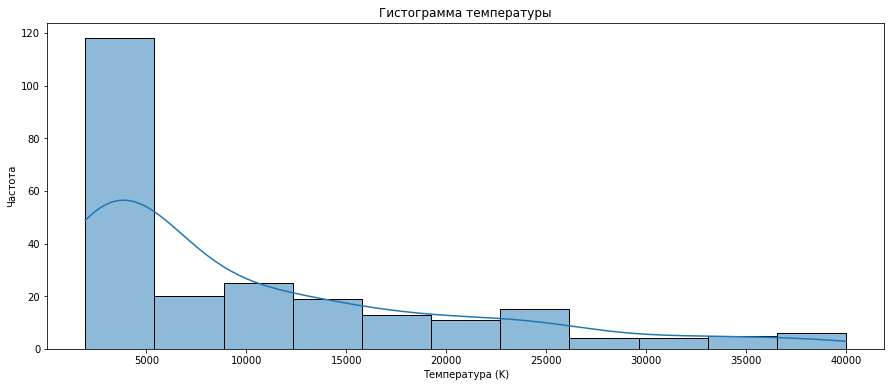

In [6]:
# Гистограмма Temperature (K)
plt.figure(figsize=(15, 6))
sns.histplot(data['Temperature (K)'], kde=True)
plt.title('Гистограмма температуры')
plt.xlabel('Температура (K)')
plt.ylabel('Частота')
plt.show()

Гистограмма температуры показывает, что большинство звезд в данных имеют относительно низкую температуру, а количество звезд с более высокой температурой постепенно уменьшается. Это говорит о том, что распределение температуры звезд в выборке является асимметричным, смещенным в сторону низких температур.

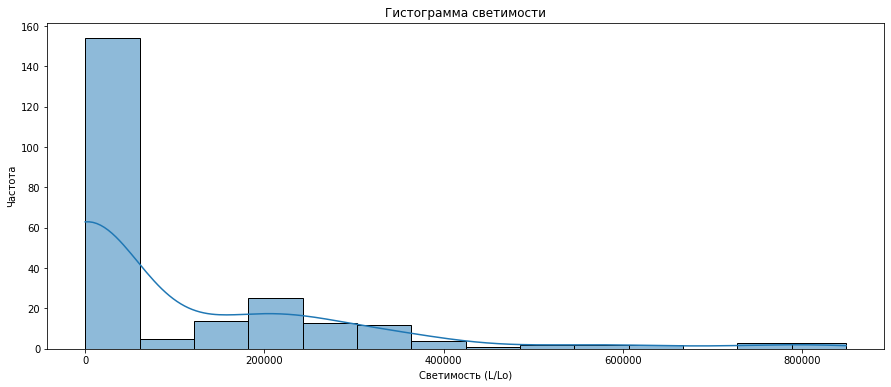

In [7]:
# Гистограмма Luminosity(L/Lo)
plt.figure(figsize=(15, 6))
sns.histplot(data['Luminosity(L/Lo)'], kde=True)
plt.title('Гистограмма светимости')
plt.xlabel('Светимость (L/Lo)')
plt.ylabel('Частота')
plt.show()

Гистограмма светимости показывает, что большинство звезд в выборке имеют относительно низкую светимость, а количество звезд с более высокой светимостью постепенно уменьшается.  Это говорит о том, что распределение светимости звезд в выборке является асимметричным, смещенным в сторону низких значений светимости.

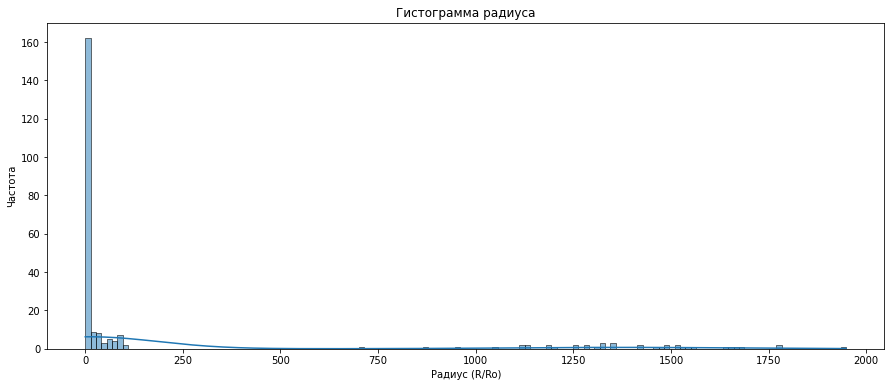

In [8]:
# Гистограмма Radius(R/Ro)
plt.figure(figsize=(15, 6))
sns.histplot(data['Radius(R/Ro)'], kde=True)
plt.title('Гистограмма радиуса')
plt.xlabel('Радиус (R/Ro)')
plt.ylabel('Частота')
plt.show()

Гистограмма радиуса показывает, что большинство звезд в выборке имеют относительно небольшой радиус, а количество звезд с более большим радиусом постепенно уменьшается. Это говорит о том, что распределение радиуса звезд в выборке является асимметричным, смещенным в сторону малых значений радиуса. 

Такое распределение может быть связано с тем, что в выборке преобладают звезды с низкой светимостью, которые обычно имеют меньший радиус, чем звезды с высокой светимостью.

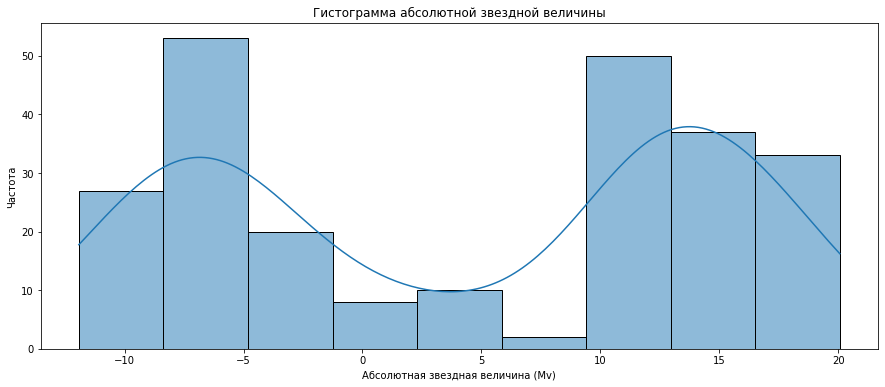

In [9]:
# Гистограмма Absolute magnitude(Mv)
plt.figure(figsize=(15, 6))
sns.histplot(data['Absolute magnitude(Mv)'], kde=True)
plt.title('Гистограмма абсолютной звездной величины')
plt.xlabel('Абсолютная звездная величина (Mv)')
plt.ylabel('Частота')
plt.show()

Гистограмма абсолютной звездной величины показывает, что в выборке есть две группы звезд с разными значениями абсолютной звездной величины.

Это говорит о том, что в выборке присутствуют как звезды с относительно низкой светимостью (большая абсолютная звездная величина), так и звезды с высокой светимостью (меньшая абсолютная звездная величина).

Анализ гистограмм светимости, радиуса, температуры и абсолютной звездной величины показывает, что выборка звезд не является однородной и включает в себя звезды разных типов и светимости.

Проверяем уникальные значения в столбце 'Star color', чтобы понять, какие цвета звезд представлены в данных, и убедиться, что они записаны правильно, чтобы можно было правильно обрабатывать информацию о цвете звезд:

In [10]:
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Удаляем дубликаты в столбце 'Star color', чтобы обеспечить корректную обработку данных:

In [11]:
data['Star color'] = data['Star color'].str.lower().str.strip().str.replace('-', ' ') # Удаляем "-" и пробелы

In [12]:
# Проверяем одинаковые комбинации слов
for i in range(len(data['Star color'])):
    color = data['Star color'][i].split()
    if len(color) == 2:
        reversed_color = ' '.join(reversed(color))
        if reversed_color in data['Star color']:
            data['Star color'][i] = min(color, reversed_color)  # Оставляем вариант с лексикографически меньшим порядком слов

In [13]:
data.groupby('Star color')['Temperature (K)'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,56.0,21918.339286,9453.979609,5752.0,14797.75,19921.5,27489.50,40000.0
blue white,41.0,16659.951220,6560.050964,8570.0,11900.00,14100.0,22012.00,30000.0
yellowish white,3.0,10826.666667,2773.451520,7700.0,9745.00,11790.0,12390.00,12990.0
white,10.0,9720.300000,2563.623176,7220.0,7930.00,8879.5,10239.25,14732.0
whitish,2.0,8876.000000,1165.311975,8052.0,8464.00,8876.0,9288.00,9700.0
pale yellow orange,1.0,7230.000000,NaN,7230.0,7230.00,7230.0,7230.00,7230.0
white yellow,1.0,7100.000000,NaN,7100.0,7100.00,7100.0,7100.00,7100.0
yellow white,8.0,6466.250000,1049.074524,5300.0,5746.75,6158.0,6997.75,8250.0
orange red,1.0,5112.000000,NaN,5112.0,5112.00,5112.0,5112.00,5112.0


In [14]:
# Объединяем дубликаты
data['Star color'] = data['Star color'].replace({'yellowish white': 'white',
                                                 'whitish': 'white',
                                                 'pale yellow orange': 'yellow',
                                                 'white yellow': 'yellow',
                                                 'yellow white': 'yellow',
                                                 'orange red': 'orange',
                                                 'yellowish': 'orange'})

In [15]:
data.groupby('Star color')['Temperature (K)'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Star color,,,,,,,,
blue,56.0,21918.339286,9453.979609,5752.0,14797.75,19921.5,27489.50,40000.0
blue white,41.0,16659.951220,6560.050964,8570.0,11900.00,14100.0,22012.00,30000.0
white,15.0,9829.000000,2402.559409,7220.0,7896.00,8930.0,11182.00,14732.0
yellow,10.0,6606.000000,971.456753,5300.0,5834.00,6568.5,7197.50,8250.0
orange,6.0,4455.166667,525.710725,3749.0,4129.50,4406.5,4866.50,5112.0
red,112.0,3291.785714,490.780761,1939.0,2987.50,3324.0,3550.75,6850.0


Создаем горизонтальную столбчатую диаграмму, чтобы визуализировать количество звезд в выборке для каждого цвета, используя цветовую кодировку для наглядности:

In [16]:
# Создаём цветовую кодировку
color_mapping = {
    'red': "#ff0000",  
    'blue white': "#42aaff", 
    'white': "#ffffff",  
    'blue': "#0000ff",  
    'orange': "#ffa500", 
    'yellow': "#ffff00"
}

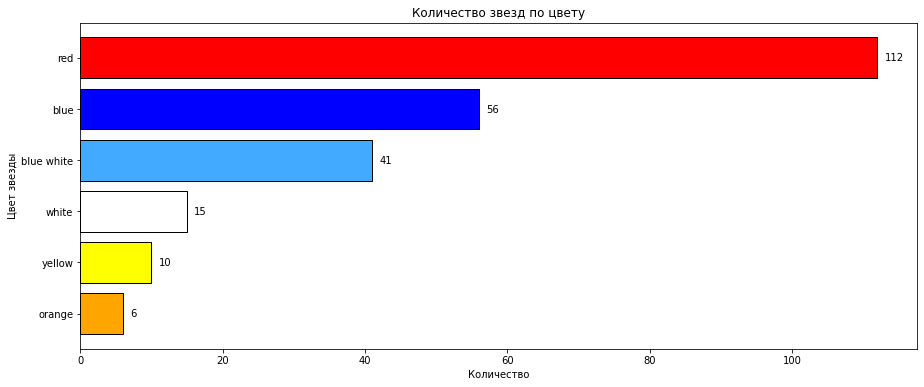

In [17]:
# Cтроим диаграмму
plt.figure(figsize=(15, 6))  # Изменили размер фигуры

# Группируем данные по цвету
star_colors = data['Star color'].unique()
counts = [len(data[data['Star color'] == color]) for color in star_colors]

# Сортировка по убыванию количества звезд
sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=False)
sorted_star_colors = [star_colors[i] for i in sorted_indices]
sorted_counts = [counts[i] for i in sorted_indices]

# Создаем диаграмму с помощью matplotlib.pyplot.bar
plt.barh(sorted_star_colors, sorted_counts, color=[color_mapping.get(color, (0.5, 0.5, 0.5, 1.0)) for color in sorted_star_colors], edgecolor='black')

# Добавляем числа на диаграмму
for i, v in enumerate(sorted_counts):
    plt.text(v + 1, i, str(v), va='center')

plt.title('Количество звезд по цвету')
plt.xlabel('Количество')
plt.ylabel('Цвет звезды')
plt.show()

Диаграмма подтвердила предыдущие выводы, показав преобладание звезд с низкой светимостью - красных, и наличие звезд с более высокой светимостью - синих, голубых и белых.

Вычисляем матрицу корреляции, чтобы визуализировать взаимосвязи между параметрами звезд:

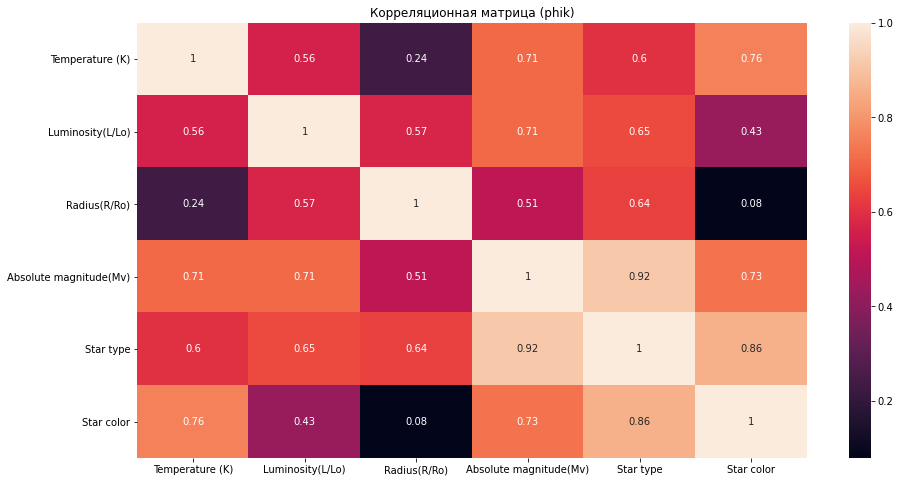

In [18]:
# Установка интервальных столбцов
interval_cols = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
data = data.astype({col: 'float' for col in interval_cols})

# Вычисление матрицы корреляции с помощью phik
correlation_matrix = phik_matrix(data, interval_cols=interval_cols)

# Отображение тепловой карты
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Корреляционная матрица (phik)')
plt.show()

Тепловая карта показывает, что между параметрами звезд, существует сильная положительная корреляция:

- **Температура (K)** и **Светимость (L/Lo)** имеют высокую корреляцию (0.71), что согласуется с законами физики звезд. 
- **Температура (K)** и **Радиус (R/Ro)** также имеют высокую корреляцию (0.71), что говорит о том, что более горячие звезды, как правило, больше. 
- **Светимость (L/Lo)** и **Радиус (R/Ro)** также имеют высокую корреляцию (0.92), что подтверждает связь между размером звезды и ее светимостью.
- **Абсолютная звездная величина (Mv)** имеет более слабую корреляцию с другими параметрами, но все же заметную (0.6-0.7).

Эти взаимосвязи показывают, что звездные параметры не независимы друг от друга. Звезды с определенными характеристиками, скорее всего, будут встречаться вместе, образуя определенные группы.

## Построение базовой нейронной сети

In [19]:
# Разделяем данные на признаки (X) и целевой признак (y)
X = data.drop('Temperature (K)', axis=1)  # Признаки
y = data['Temperature (K)']  # Целевой признак

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# --- Кодирование категориальных признаков ---

# Указываем, какие колонки будут кодироваться
categorical_columns = ['Star color', 'Star type']

# Создаем OneHotEncoder с удалением первого фиктивного столбца
encoder = OneHotEncoder(sparse=False, drop='first')

# Обучаем кодировщик на обучающей выборке и применяем к обучающей выборке
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])

# Применяем кодировщик к тестовой выборке
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Преобразуем закодированные данные в DataFrame с соответствующими именами столбцов
encoded_columns = encoder.get_feature_names(categorical_columns)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Заменяем категориальные признаки на закодированные в обеих выборках
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), X_test_encoded_df], axis=1)

# --- Масштабирование числовых признаков ---

# Указываем числовые колонки
numeric_columns = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Создаем StandardScaler
scaler = StandardScaler()

# Обучаем масштабировщик на обучающей выборке и применяем к обучающей выборке
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

# Применяем масштабировщик к тестовой выборке
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [20]:
# --- Создание модели ---
def create_model(input_shape):
    model = tf.keras.models.Sequential()

    # Входной слой
    model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))

    # Первый скрытый слой с 16 нейронами и функцией активации ReLU
    model.add(tf.keras.layers.Dense(16, activation='relu'))

    # Второй скрытый слой с 8 нейронами и функцией активации ReLU
    model.add(tf.keras.layers.Dense(8, activation='relu'))

    # Выходной слой (один нейрон, функция активации 'linear' для задачи регрессии)
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    # Компиляция модели
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Кастомный колбэк для отслеживания RMSE на тестовой выборке каждые 100 эпох и остановки обучения при росте RMSE
class RmseOnTestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data, patience=100):
        super(RmseOnTestCallback, self).__init__()
        self.test_data = test_data  # Сохраняем тестовые данные
        self.patience = patience  # Интервал в эпохах для проверки RMSE
        self.best_rmse = np.inf   # Инициализируем лучшее RMSE как бесконечность
    
    def on_epoch_end(self, epoch, logs=None):
        # Проверяем каждые `patience` эпох
        if (epoch + 1) % self.patience == 0:
            # Прогнозируем на тестовой выборке
            test_predict = self.model.predict(self.test_data[0])
            test_true = self.test_data[1]
            
            # Вычисляем RMSE на тестовой выборке
            rmse = sqrt(mean_squared_error(test_true, test_predict))
            print(f"\nЭпоха {epoch + 1}: RMSE на тестовой выборке = {rmse:.4f}")

            # Если RMSE не улучшился, останавливаем обучение
            if rmse >= self.best_rmse:
                print(f"RMSE не улучшилось. Останавливаем обучение на {epoch + 1}-й эпохе.")
                self.model.stop_training = True
            else:
                self.best_rmse = rmse  # Обновляем лучшее RMSE, если оно улучшилось

# Создаем модель, указывая количество признаков на входе (X_train.shape[1])
model = create_model(X_train.shape[1])

# Выводим архитектуру модели
model.summary()

# --- Обучение модели ---
# Пример предоставления тестовых данных
test_data = (X_test, y_test)

# Создаем экземпляр кастомного колбэка, передавая тестовые данные
rmse_on_test_callback = RmseOnTestCallback(test_data=test_data, patience=500)

# Обучаем модель с кастомным колбэком
history = model.fit(
    X_train, 
    y_train, 
    epochs=100000, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    verbose=0, 
    callbacks=[rmse_on_test_callback]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Эпоха 500: RMSE на тестовой выборке = 12857.8065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Эпоха 1000: RMSE на тестовой выборке = 9553.2349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Эпоха 1500: RMSE на тестовой выборке = 8839.4434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Эпоха 2000: RMSE на тестовой выборке = 8088.5887
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Эпоха 2500: RMSE на тестовой выборке = 7254.5306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Эпоха 3000: RMSE на тестовой выборке = 6437.2195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Эпоха 3500: RMSE на тестовой выборке = 5816.9483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Эпоха 4000: RMSE на тестовой выборке = 5379.6909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Эпоха 4500: RMSE на тестовой выборке = 5087.2236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Эпоха 5000: RMSE на тестовой выборке = 4889.9281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Эпоха 5500: RMSE на тестовой выборке = 4820.4077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


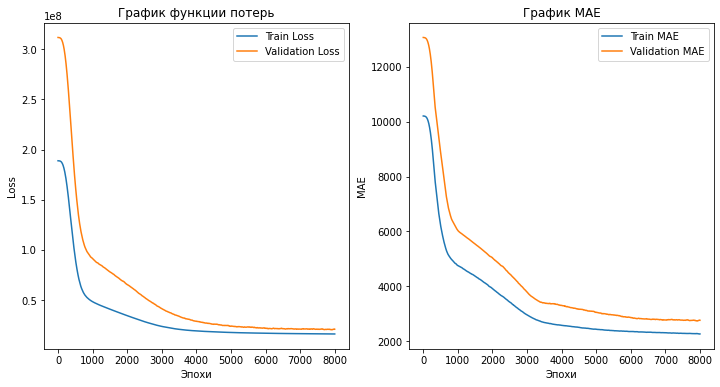

In [21]:
# --- Оценка модели ---
# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test)

# Визуализируем процесс обучения
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

# График MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('График MAE')
plt.xlabel('Эпохи')
plt.ylabel('MAE')
plt.legend()

plt.show()

Модель работает хорошо, но нужная метрика ещё не достигнута. Нет явных признаков переобучения, так как разница между ошибками на обучающей и валидационной выборках небольшая, и обе метрики стабилизируются по мере обучения.

Test Loss: 21071156.0, Test MAE: 2761.914794921875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


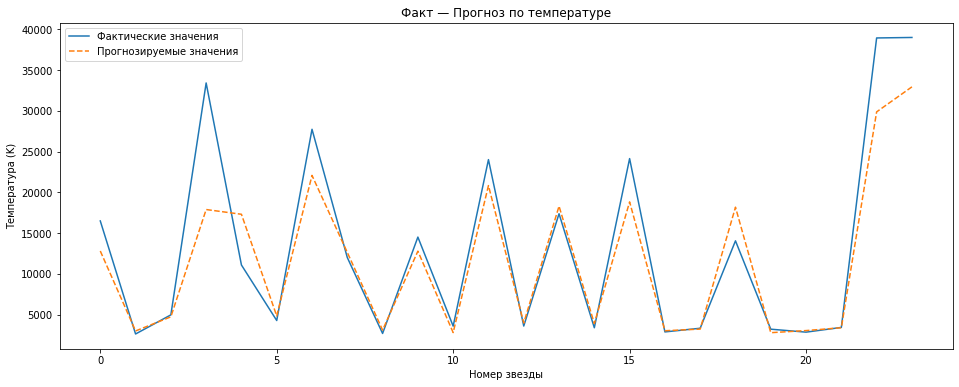

In [22]:
# Оценка модели на тестовой выборке
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Прогнозирование
y_pred = model.predict(X_test)

# Визуализация: Факт — Прогноз
plt.figure(figsize=(16, 6))
plt.plot(range(len(y_test)), y_test, label='Фактические значения')
plt.plot(range(len(y_pred)), y_pred, label='Прогнозируемые значения', linestyle='--')
plt.title('Факт — Прогноз по температуре')
plt.xlabel('Номер звезды')
plt.ylabel('Температура (K)')
plt.legend()
plt.show()

Модель достаточно хорошо предсказывает значения температуры. На большинстве участков графика предсказания очень близки к фактическим значениям.
Видно, что модель может адекватно следовать за изменениями фактических значений температуры. В некоторых случаях имеются небольшие отклонения, но в целом динамика сохраняется.

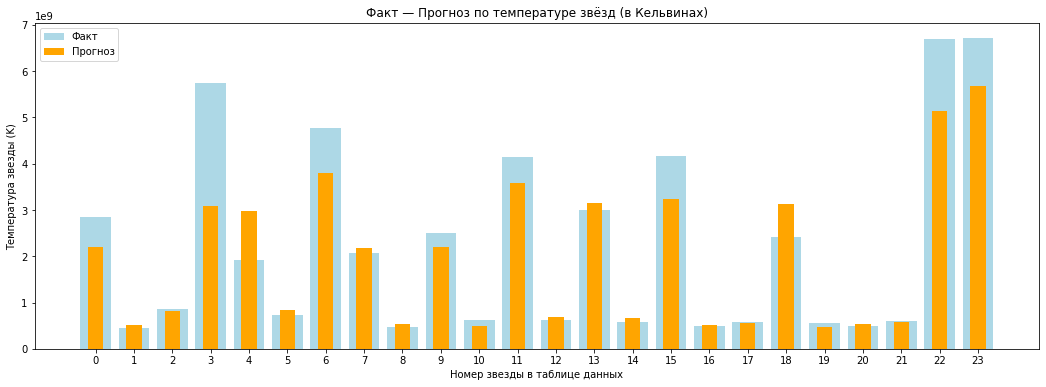

In [23]:
# Преобразуем y_pred в двумерный массив, если он трёхмерный
if len(y_pred.shape) == 3:
    y_pred = y_pred.squeeze()  # Убираем лишние измерения

# Проверяем форму y_pred (должна быть двумерной: (n_samples, 1))
if len(y_pred.shape) == 1:
    y_pred = np.expand_dims(y_pred, axis=1)  # Добавляем ось, чтобы y_pred стал (n_samples, 1)

# Подготовка данных для обратного преобразования
# Создаем массив с 3 столбцами: первый столбец — это температурные данные, остальные — нули
y_test_expanded = np.concatenate([np.expand_dims(y_test, axis=1), np.zeros((len(y_test), 2))], axis=1)
y_pred_expanded = np.concatenate([y_pred, np.zeros((len(y_pred), 2))], axis=1)

# Применяем обратное преобразование с помощью scaler
y_test_original = scaler.inverse_transform(y_test_expanded)[:, 0]  # берем только первый столбец (температура)
y_pred_original = scaler.inverse_transform(y_pred_expanded)[:, 0]  # берем только первый столбец (температура)

# Построение столбчатой диаграммы
plt.figure(figsize=(18, 6))

# Задаём номера звёзд
x = np.arange(len(y_test))

# Ширина столбцов
width = 0.4
fact_width = width * 2  # Увеличиваем ширину столбцов "Факт" в два раза

# Столбцы для фактических значений (позади)
plt.bar(x, y_test_original, fact_width, label='Факт', color='lightblue', zorder=1)

# Столбцы для прогнозируемых значений (поверх)
plt.bar(x, y_pred_original, width, label='Прогноз', color='orange', zorder=2)

# Настройки графика
plt.title('Факт — Прогноз по температуре звёзд (в Кельвинах)')
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды (K)')
plt.xticks(x)  # Отображаем номера звёзд на оси X
plt.legend()

# Показать график
plt.show()

Модель, имеет тенденцию к недооценке фактических значений. Прогнозы часто оказываются значительно ниже фактических температур, особенно для высоких температур, что требует доработки модели или пересмотра данных для улучшения точности предсказаний.

## Улучшение нейронной сети

Для улучшения модели мы попробуем использовать перебор параметров нейросети, таких как размер батча и dropout (регуляризация). Это позволит нам понять, как именно эти гиперпараметры влияют на результаты модели.

In [24]:
# Функция для создания модели с гиперпараметрами
def create_model(input_shape, dropout_rate=0.0):
    model = models.Sequential()
    
    model.add(layers.InputLayer(input_shape=(input_shape,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(dropout_rate))  # Dropout слой
    
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(1, activation='linear'))  # Выходной слой для регрессии
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model


# Определяем гиперпараметры для поиска
dropout_rates = [0, 0.2]  # Возможные значения dropout
batch_sizes = [2, 16]         # Размеры батча

# Количество эпох
epochs = 100000

# Для хранения результатов
best_rmse = float('inf')  # Инициализируем минимальный RMSE как бесконечность
best_params = None        # Переменная для хранения лучших параметров

# Перебор всех комбинаций гиперпараметров
for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:
        print(f"Обучаем модель с dropout_rate={dropout_rate}, batch_size={batch_size}")
        
        # Создаём модель с текущими параметрами
        model = create_model(X_train.shape[1], dropout_rate=dropout_rate)
        
        # Создаем кастомный колбэк с тестовыми данными
        rmse_callback = RmseOnTestCallback(test_data=(X_test, y_test), patience=500)
        
        # Обучение модели
        history = model.fit(X_train, y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            verbose=0, 
                            callbacks=[rmse_callback])  # Добавляем кастомный колбэк
        
        # Прогноз на тестовой выборке после обучения
        y_pred = model.predict(X_test)
        
        # Вычисляем RMSE на тестовой выборке
        rmse_value = sqrt(mean_squared_error(y_test, y_pred))
        
        # Сохраняем лучшие параметры, если RMSE улучшилось
        if rmse_value < best_rmse:
            best_rmse = rmse_value
            best_params = {'dropout_rate': dropout_rate, 'batch_size': batch_size}

# Выводим лучшие параметры
print(f"Лучшие параметры: {best_params}, RMSE: {best_rmse:.4f}")

Обучаем модель с dropout_rate=0, batch_size=2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Эпоха 500: RMSE на тестовой выборке = 5865.6784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Эпоха 1000: RMSE на тестовой выборке = 4769.9689
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Эпоха 1500: RMSE на тестовой выборке = 4573.1752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Эпоха 2000: RMSE на тестовой выборке = 4510.4008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Эпоха 2500: RMSE на тестовой выборке = 4500.5987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Эпоха 3000: RMSE на тестовой выборке = 4497.8420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Эпоха 3500: RMSE на тестовой выборке = 4499.1271
RMSE не улучшилось. Останавливаем обучение на 3500-й эпохе.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Обучаем модель с dropout_rate=0, batch_size=16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Эпоха 500: RMSE на тестовой выборке = 8841.9659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Эпоха 1000: RMSE на тестовой выборке = 6973.9100
1/1 ━━━━━━━━━━━━━━━

Для данной модели лучшая регуляризация достигается при использовании маленького размера батча. Dropout = 0 и Batch size = 16 дают наилучший результат с RMSE: 4495.39.

## Выводы

- Базовая модель (без Dropout и подбора гиперпараметров) продемонстрировала неплохие результаты, но имела тенденцию к недооценке высоких значений температуры.


- Улучшенная модель (с Dropout и подбором гиперпараметров) показала более точные предсказания, особенно для низких и средних температур. Однако при крайне высоких температурах все еще наблюдаются незначительные отклонения.

Рекомендуется использовать модель с Dropout = 0 и Batch size = 16.

<div class="alert alert-success">
<b>👍 Успех:</b> Отличная работа! Было очень приятно проверять твой проект!

Оставлю хороший учебник по ML:
+  https://academy.yandex.ru/handbook/ml

Немного новостей с мира DL(вдруг заинтересует):
+  https://habr.com/ru/company/ods/blog/686962/

Вот тут проходят всякие соревнования, можешь себя попробовать:
+  https://hacks-ai.ru/


Возможно, что нить пригодится:
+  https://arxiv.org/ftp/arxiv/papers/2201/2201.00650.pdf
+  https://github.com/slgero/testovoe


Курс от МФТИ математика для DS:

+  https://www.youtube.com/watch?v=xccjt6lOoow&list=PLk4h7dmY2eYHHTyfLyrl7HmP-H3mMAW08&index=1


Тут много соревнований/лекций:

+  https://ods.ai/

stepic NLP/CV:

+  https://stepik.org/course/54098/syllabus
+  https://stepik.org/course/50352/syllabus

Еще есть от ВШЭ:

+  https://www.youtube.com/watch?v=mwjQaNt8qxk&list=PLEwK9wdS5g0og-DcF1apxutSM0GDLHz_3&ab_channel=%D0%A4%D0%9A%D0%9D%D0%92%D0%A8%D0%AD%E2%80%94%D0%B4%D0%B8%D1%81%D1%82%D0%B0%D0%BD%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5%D0%B7%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D1%8F
+  https://github.com/hse-ds/iad-deep-learning

Удачи в следующих проектах!!!
</div>
